# Segmentación Semántica de Gliomas Cerebrales en Imágenes de Resonancia Magnética (MRI) utilizando Arquitecturas U-Net con Transfer Learning y Explicabilidad

Integrante: Christian Jefrey Fonseca Rodriguez

Grupo 9

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib  # Para leer archivos de formato NIfTI
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp # Biblioteca de alto nivel para modelos de segmentación
from tqdm import tqdm # Para barras de progreso
from sklearn.model_selection import train_test_split
import cv2 # OpenCV para manipulación de imágenes como redimensionamiento y superposición

# Importación de SciPy para métricas avanzadas (Distancia de Hausdorff)
from scipy.spatial.distance import cdist

# Importaciones para XAI (Grad-CAM)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

c:\Users\chris\anaconda3\envs\vision\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuración del dispositivo (GPU si está disponible, de lo contrario CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cuda


## DEFINICIÓN DE PARÁMETROS Y RUTAS

Parámetros globales para el entrenamiento y el procesamiento de datos.

In [3]:
# Ruta al directorio principal que contiene los datos de BraTS 2021
DATA_DIR = 'F:/Proyectos/brain_segmentation/data/BraTS2021_Training_Data/'

# Parámetros del modelo y entrenamiento
IMG_SIZE = 240 # Tamaño al que se redimensionarán las imágenes
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4
ENCODER = 'resnet50'
PRETRAINED_WEIGHTS = 'imagenet'

## CARGA DE DATOS Y PRE-PROCESAMIENTO

Funciones para encontrar, cargar y pre-procesar los datos de BraTS.

In [4]:
def get_patient_paths(data_dir):
    """
    Obtiene las rutas a las carpetas de cada paciente.
    """
    patient_folders = glob.glob(os.path.join(data_dir, 'BraTS2021_*'))
    return patient_folders

def preprocess_mask(mask):
    """
    Pre-procesa la máscara de segmentación de BraTS.ssss
    Las etiquetas originales son 1 (NCR), 2 (ED), 4 (ET).
    Se mapean a 1 (NCR), 2 (ED), 3 (ET) para facilitar el manejo en PyTorch.
    La clase 0 es el fondo.
    """
    mask_processed = np.zeros_like(mask)
    mask_processed[mask == 1] = 1  # NCR
    mask_processed[mask == 2] = 2  # ED
    mask_processed[mask == 4] = 3  # ET
    return mask_processed

def load_and_preprocess_sample(patient_path):
    """
    Carga las 4 modalidades de MRI y la máscara para un paciente,
    y las pre-procesa.
    Retorna una lista de pares (imagen_apilada, mascara_procesada) para los cortes con tumor.
    """
    processed_samples = []
    try:
        # Cargar las 4 modalidades y la máscara
        # glob.glob devuelve una lista, tomamos el primer elemento 
        flair_path = glob.glob(os.path.join(patient_path, '*_flair.nii.gz'))
        t1_path = glob.glob(os.path.join(patient_path, '*_t1.nii.gz'))
        t1ce_path = glob.glob(os.path.join(patient_path, '*_t1ce.nii.gz'))
        t2_path = glob.glob(os.path.join(patient_path, '*_t2.nii.gz'))
        seg_path = glob.glob(os.path.join(patient_path, '*_seg.nii.gz'))

        flair_img = nib.load(flair_path[0]).get_fdata()
        t1_img = nib.load(t1_path[0]).get_fdata()
        t1ce_img = nib.load(t1ce_path[0]).get_fdata()
        t2_img = nib.load(t2_path[0]).get_fdata()
        seg_mask = nib.load(seg_path[0]).get_fdata()

        # Iterar a través de los cortes axiales (última dimensión)
        for i in range(flair_img.shape[2]):
            mask_slice = seg_mask[:, :, i]
            
            # Solo procesar cortes que contienen tumor para enfocar el entrenamiento
            if np.sum(mask_slice) > 0:
                # Normalización Z-score para cada modalidad
                flair_slice = (flair_img[:, :, i] - np.mean(flair_img[:, :, i])) / (np.std(flair_img[:, :, i]) + 1e-8)
                t1_slice = (t1_img[:, :, i] - np.mean(t1_img[:, :, i])) / (np.std(t1_img[:, :, i]) + 1e-8)
                t1ce_slice = (t1ce_img[:, :, i] - np.mean(t1ce_img[:, :, i])) / (np.std(t1ce_img[:, :, i]) + 1e-8)
                t2_slice = (t2_img[:, :, i] - np.mean(t2_img[:, :, i])) / (np.std(t2_img[:, :, i]) + 1e-8)

                # Apilar las 4 modalidades para crear una imagen de 4 canales
                # La forma final debe ser (canales, altura, anchura) para PyTorch
                stacked_img = np.stack([flair_slice, t1_slice, t1ce_slice, t2_slice], axis=0)
                
                # Pre-procesar la máscara
                processed_mask = preprocess_mask(mask_slice)

                processed_samples.append((stacked_img, processed_mask))
        
        return processed_samples

    except Exception as e:
        print(f"Error procesando paciente {patient_path}: {e}")
        return processed_samples # Devolver lista vacía si hay error

## GENERADOR DE DATOS DE PYTORCH

In [5]:
class BraTSDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Obtener la imagen apilada y la máscara
        image, mask = self.data[idx]
        
        # Convertir a tensores de PyTorch
        # Asegurarse de que los tipos de datos son correctos
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()
        
        return image, mask

### Métrica: Distancia de Hausdorff 95%

In [6]:
def calculate_hd95(pred_mask, gt_mask):
    """
    Calcula la Distancia de Hausdorff del 95º percentil entre dos máscaras binarias.
    Utiliza SciPy y NumPy.
    """
    pred_points = np.argwhere(pred_mask)
    gt_points = np.argwhere(gt_mask)

    # Si una máscara está vacía y la otra no, la distancia es grande.
    # Si ambas están vacías, la distancia es 0.
    if len(pred_points) == 0 and len(gt_points) == 0:
        return 0.0
    if len(pred_points) == 0 or len(gt_points) == 0:
        # Retorna una penalización grande, como la diagonal de la imagen
        return np.sqrt(pred_mask.shape[0]**2 + pred_mask.shape[1]**2)

    # Calcular las distancias de cada punto en un conjunto al punto más cercano en el otro
    distances_pred_to_gt = cdist(pred_points, gt_points).min(axis=1)
    distances_gt_to_pred = cdist(gt_points, pred_points).min(axis=1)

    # Obtener el 95º percentil de estas distancias
    hd95_pred_to_gt = np.percentile(distances_pred_to_gt, 95)
    hd95_gt_to_pred = np.percentile(distances_gt_to_pred, 95)

    # La HD95 es el máximo de las dos distancias dirigidas
    return max(hd95_pred_to_gt, hd95_gt_to_pred)

## DEFINICIÓN DE ARQUITECTURAS DE MODELOS

In [7]:
# Implementación de Attention U-Net
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        g1, x1 = self.W_g(g), self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, 3, padding=1), nn.BatchNorm2d(ch_out), nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, 3, padding=1), nn.BatchNorm2d(ch_out), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super(AttentionUNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512)
        self.conv5 = ConvBlock(512, 1024)
        self.up5 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.att5 = AttentionGate(512, 512, 256)
        self.up_conv5 = ConvBlock(1024, 512)
        self.up4 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.att4 = AttentionGate(256, 256, 128)
        self.up_conv4 = ConvBlock(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.att3 = AttentionGate(128, 128, 64)
        self.up_conv3 = ConvBlock(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.att2 = AttentionGate(64, 64, 32)
        self.up_conv2 = ConvBlock(128, 64)
        self.conv_out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.pool(x1); x2 = self.conv2(x2)
        x3 = self.pool(x2); x3 = self.conv3(x3)
        x4 = self.pool(x3); x4 = self.conv4(x4)
        x5 = self.pool(x4); x5 = self.conv5(x5)
        d5 = self.up5(x5)
        x4 = self.att5(d5, x4)
        d5 = self.up_conv5(torch.cat((x4, d5), 1))
        d4 = self.up4(d5)
        x3 = self.att4(d4, x3)
        d4 = self.up_conv4(torch.cat((x3, d4), 1))
        d3 = self.up3(d4)
        x2 = self.att3(d3, x2)
        d3 = self.up_conv3(torch.cat((x2, d3), 1))
        d2 = self.up2(d3)
        x1 = self.att2(d2, x1)
        d2 = self.up_conv2(torch.cat((x1, d2), 1))
        return self.conv_out(d2)

## ENTRENAMIENTO Y VALIDACIÓN

In [8]:
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate_epoch(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    dice_score, sensitivity, hd95 = 0.0, 0.0, 0.0
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            running_loss += loss.item()
            
            pred_masks = torch.softmax(outputs, dim=1).argmax(dim=1)
            
            # Mover a CPU y convertir a NumPy para métricas
            pred_masks_np = pred_masks.cpu().numpy()
            masks_np = masks.cpu().numpy()
            
            # Calcular métricas por lote
            batch_dice, batch_sens, batch_hd95 = [], [], []
            for i in range(images.size(0)): # Iterar sobre cada imagen en el lote
                sample_dice, sample_sens, sample_hd95 = [], [], []
                for c in range(1, 4): # Iterar sobre cada clase de tumor (1, 2, 3)
                    pred_c = (pred_masks_np[i] == c)
                    gt_c = (masks_np[i] == c)
                    
                    tp = np.sum(pred_c * gt_c)
                    fp = np.sum(pred_c * (1 - gt_c))
                    fn = np.sum((1 - pred_c) * gt_c)
                    
                    sample_dice.append((2 * tp) / (2 * tp + fp + fn + 1e-8))
                    sample_sens.append(tp / (tp + fn + 1e-8))
                    sample_hd95.append(calculate_hd95(pred_c, gt_c))
                
                batch_dice.append(np.mean(sample_dice))
                batch_sens.append(np.mean(sample_sens))
                batch_hd95.append(np.mean(sample_hd95))
            
            dice_score += np.mean(batch_dice)
            sensitivity += np.mean(batch_sens)
            hd95 += np.mean(batch_hd95)

    return (running_loss / len(loader), 
            dice_score / len(loader), 
            sensitivity / len(loader), 
            hd95 / len(loader))

## PIPELINE DE ENTRENAMIENTO COMPARATIVO

In [9]:
def run_training_pipeline(model, model_name, train_loader, val_loader, device):
    print(f"\n{'='*20} Entrenando Modelo: {model_name} {'='*20}")
    
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
    
    best_val_dice = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_sensitivity': [], 'val_hd95': []}
    
    for epoch in range(EPOCHS):
        print(f"--- Epoch {epoch+1}/{EPOCHS} ---")
        train_loss = train_epoch(model, tqdm(train_loader, desc="Entrenando"), optimizer, loss_fn, device)
        val_loss, val_dice, val_sens, val_hd = validate_epoch(model, tqdm(val_loader, desc="Validando"), loss_fn, device)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_sensitivity'].append(val_sens)
        history['val_hd95'].append(val_hd)
        
        print(f"Pérdida Val: {val_loss:.4f} | Dice Val: {val_dice:.4f} | Sensibilidad Val: {val_sens:.4f} | HD95 Val: {val_hd:.2f}")
        
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), f'best_model_{model_name.replace(" ", "_").replace("+", "plus").lower()}.pth')
            print(f"Mejor modelo guardado.")
            
        scheduler.step(val_loss)
        
    return history, best_val_dice

## EJECUCIÓN PRINCIPAL

In [10]:
# Cargar todas las rutas de pacientes
all_patient_paths = get_patient_paths(DATA_DIR)

# En un entrenamiento real, se usarían todos los datos.
all_patient_paths = all_patient_paths[:200] 

In [11]:
# Pre-procesar todos los datos (esto puede tardar)
print("Pre-procesando datos...")
all_samples = []
for path in tqdm(all_patient_paths, desc="Procesando Pacientes"):
    all_samples.extend(load_and_preprocess_sample(path))

print(f"Total de cortes con tumor encontrados: {len(all_samples)}")

Pre-procesando datos...


Procesando Pacientes: 100%|██████████| 200/200 [02:07<00:00,  1.57it/s]

Total de cortes con tumor encontrados: 12905


In [12]:
# Dividir los datos en entrenamiento y validación
train_data, val_data = train_test_split(all_samples, test_size=0.2, random_state=42)

train_dataset = BraTSDataset(train_data)
val_dataset = BraTSDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# Modelos a comparar
models_to_train = {
        "U-Net (ResNet50)": smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights='imagenet', 
            in_channels=4, 
            classes=4),
        "Attention U-Net": AttentionUNet(
            in_channels=4, 
            out_channels=4),
        "DeepLabv3+": smp.DeepLabV3Plus(
            encoder_name=ENCODER, 
            encoder_weights=PRETRAINED_WEIGHTS, 
            in_channels=4, 
            classes=4),
        "PSPNet": smp.PSPNet(
            encoder_name=ENCODER, 
            encoder_weights=PRETRAINED_WEIGHTS, 
            in_channels=4, 
            classes=4),
        "SegFormer": smp.Unet(
            encoder_name='mit_b2', 
            encoder_weights=PRETRAINED_WEIGHTS, 
            in_channels=4, 
            classes=4) # Usando U-Net con encoder de SegFormer
    }

In [14]:
# Corriendo el entrenamiento
results_history = {}
best_scores = {}

name = "U-Net (ResNet50)"
model_instance = models_to_train[name]

history, best_dice = run_training_pipeline(model_instance, name, train_loader, val_loader, DEVICE)
results_history[name] = history
best_scores[name] = best_dice


==================== Entrenando Modelo: U-Net (ResNet50) ====================
--- Epoch 1/50 ---


Validando: 100%|██████████| 323/323 [00:59<00:00,  5.47it/s]


Pérdida Val: 0.1216 | Dice Val: 0.5244 | Sensibilidad Val: 0.5226 | HD95 Val: 28.03
Mejor modelo guardado.
--- Epoch 2/50 ---


Validando: 100%|██████████| 323/323 [01:24<00:00,  3.82it/s]


Pérdida Val: 0.0987 | Dice Val: 0.5500 | Sensibilidad Val: 0.5530 | HD95 Val: 23.75
Mejor modelo guardado.
--- Epoch 3/50 ---


Validando: 100%|██████████| 323/323 [01:39<00:00,  3.24it/s]


Pérdida Val: 0.0898 | Dice Val: 0.5618 | Sensibilidad Val: 0.5712 | HD95 Val: 22.05
Mejor modelo guardado.
--- Epoch 4/50 ---


Validando: 100%|██████████| 323/323 [01:41<00:00,  3.17it/s]


Pérdida Val: 0.0919 | Dice Val: 0.5632 | Sensibilidad Val: 0.5867 | HD95 Val: 20.82
Mejor modelo guardado.
--- Epoch 5/50 ---


Validando: 100%|██████████| 323/323 [01:25<00:00,  3.76it/s]


Pérdida Val: 0.0781 | Dice Val: 0.5817 | Sensibilidad Val: 0.5814 | HD95 Val: 18.49
Mejor modelo guardado.
--- Epoch 6/50 ---


Validando: 100%|██████████| 323/323 [01:38<00:00,  3.26it/s]


Pérdida Val: 0.0811 | Dice Val: 0.5783 | Sensibilidad Val: 0.5994 | HD95 Val: 19.30
--- Epoch 7/50 ---


Validando: 100%|██████████| 323/323 [01:16<00:00,  4.20it/s]


Pérdida Val: 0.0763 | Dice Val: 0.5773 | Sensibilidad Val: 0.5655 | HD95 Val: 20.46
--- Epoch 8/50 ---


Validando: 100%|██████████| 323/323 [01:35<00:00,  3.40it/s]


Pérdida Val: 0.0723 | Dice Val: 0.5901 | Sensibilidad Val: 0.6011 | HD95 Val: 17.43
Mejor modelo guardado.
--- Epoch 9/50 ---


Validando: 100%|██████████| 323/323 [01:24<00:00,  3.84it/s]


Pérdida Val: 0.0705 | Dice Val: 0.5833 | Sensibilidad Val: 0.5776 | HD95 Val: 18.72
--- Epoch 10/50 ---


Validando: 100%|██████████| 323/323 [01:22<00:00,  3.90it/s]


Pérdida Val: 0.0666 | Dice Val: 0.5970 | Sensibilidad Val: 0.5977 | HD95 Val: 17.16
Mejor modelo guardado.
--- Epoch 11/50 ---


Validando: 100%|██████████| 323/323 [01:24<00:00,  3.81it/s]


Pérdida Val: 0.0649 | Dice Val: 0.5983 | Sensibilidad Val: 0.6022 | HD95 Val: 16.52
Mejor modelo guardado.
--- Epoch 12/50 ---


Validando: 100%|██████████| 323/323 [01:31<00:00,  3.52it/s]


Pérdida Val: 0.0632 | Dice Val: 0.6018 | Sensibilidad Val: 0.6004 | HD95 Val: 15.74
Mejor modelo guardado.
--- Epoch 13/50 ---


Validando: 100%|██████████| 323/323 [01:33<00:00,  3.45it/s]


Pérdida Val: 0.0691 | Dice Val: 0.5982 | Sensibilidad Val: 0.6162 | HD95 Val: 18.13
--- Epoch 14/50 ---


Validando: 100%|██████████| 323/323 [01:28<00:00,  3.67it/s]


Pérdida Val: 0.0638 | Dice Val: 0.6038 | Sensibilidad Val: 0.6071 | HD95 Val: 16.92
Mejor modelo guardado.
--- Epoch 15/50 ---


Validando: 100%|██████████| 323/323 [00:55<00:00,  5.82it/s]


Pérdida Val: 0.0633 | Dice Val: 0.5986 | Sensibilidad Val: 0.5881 | HD95 Val: 16.12
--- Epoch 16/50 ---


Validando: 100%|██████████| 323/323 [00:57<00:00,  5.66it/s]


Pérdida Val: 0.0602 | Dice Val: 0.6077 | Sensibilidad Val: 0.6154 | HD95 Val: 14.97
Mejor modelo guardado.
--- Epoch 17/50 ---


Validando: 100%|██████████| 323/323 [01:20<00:00,  4.01it/s]


Pérdida Val: 0.0605 | Dice Val: 0.6060 | Sensibilidad Val: 0.6080 | HD95 Val: 15.12
--- Epoch 18/50 ---


Validando: 100%|██████████| 323/323 [01:27<00:00,  3.70it/s]


Pérdida Val: 0.0591 | Dice Val: 0.6079 | Sensibilidad Val: 0.6052 | HD95 Val: 14.18
Mejor modelo guardado.
--- Epoch 19/50 ---


Validando: 100%|██████████| 323/323 [01:33<00:00,  3.45it/s]


Pérdida Val: 0.0574 | Dice Val: 0.6098 | Sensibilidad Val: 0.6142 | HD95 Val: 14.98
Mejor modelo guardado.
--- Epoch 20/50 ---


Validando: 100%|██████████| 323/323 [01:30<00:00,  3.57it/s]


Pérdida Val: 0.0651 | Dice Val: 0.6028 | Sensibilidad Val: 0.6149 | HD95 Val: 21.40
--- Epoch 21/50 ---


Validando: 100%|██████████| 323/323 [01:27<00:00,  3.68it/s]


Pérdida Val: 0.0601 | Dice Val: 0.6069 | Sensibilidad Val: 0.6090 | HD95 Val: 15.51
--- Epoch 22/50 ---


Validando: 100%|██████████| 323/323 [01:28<00:00,  3.64it/s]


Pérdida Val: 0.0670 | Dice Val: 0.5966 | Sensibilidad Val: 0.5935 | HD95 Val: 16.47
--- Epoch 23/50 ---


Validando: 100%|██████████| 323/323 [01:15<00:00,  4.29it/s]


Pérdida Val: 0.0573 | Dice Val: 0.6118 | Sensibilidad Val: 0.6085 | HD95 Val: 14.50
Mejor modelo guardado.
--- Epoch 24/50 ---


Validando: 100%|██████████| 323/323 [00:58<00:00,  5.51it/s]


Pérdida Val: 0.0607 | Dice Val: 0.6066 | Sensibilidad Val: 0.6104 | HD95 Val: 14.68
--- Epoch 25/50 ---


Validando: 100%|██████████| 323/323 [00:58<00:00,  5.56it/s]


Pérdida Val: 0.0592 | Dice Val: 0.6060 | Sensibilidad Val: 0.6034 | HD95 Val: 14.37
--- Epoch 26/50 ---


Validando: 100%|██████████| 323/323 [00:57<00:00,  5.60it/s]


Pérdida Val: 0.0589 | Dice Val: 0.6113 | Sensibilidad Val: 0.6188 | HD95 Val: 14.91
--- Epoch 27/50 ---


Validando: 100%|██████████| 323/323 [00:58<00:00,  5.53it/s]


Pérdida Val: 0.0549 | Dice Val: 0.6139 | Sensibilidad Val: 0.6126 | HD95 Val: 14.51
Mejor modelo guardado.
--- Epoch 28/50 ---


Validando: 100%|██████████| 323/323 [01:33<00:00,  3.47it/s]


Pérdida Val: 0.0553 | Dice Val: 0.6135 | Sensibilidad Val: 0.6121 | HD95 Val: 14.33
--- Epoch 29/50 ---


Validando: 100%|██████████| 323/323 [01:12<00:00,  4.46it/s]


Pérdida Val: 0.0559 | Dice Val: 0.6098 | Sensibilidad Val: 0.5993 | HD95 Val: 14.71
--- Epoch 30/50 ---


Validando: 100%|██████████| 323/323 [00:52<00:00,  6.17it/s]


Pérdida Val: 0.0606 | Dice Val: 0.6062 | Sensibilidad Val: 0.6021 | HD95 Val: 16.54
--- Epoch 31/50 ---


Validando: 100%|██████████| 323/323 [00:51<00:00,  6.27it/s]


Pérdida Val: 0.0534 | Dice Val: 0.6158 | Sensibilidad Val: 0.6127 | HD95 Val: 14.44
Mejor modelo guardado.
--- Epoch 32/50 ---


Validando: 100%|██████████| 323/323 [00:50<00:00,  6.33it/s]


Pérdida Val: 0.0544 | Dice Val: 0.6152 | Sensibilidad Val: 0.6078 | HD95 Val: 16.17
--- Epoch 33/50 ---


Validando: 100%|██████████| 323/323 [00:50<00:00,  6.34it/s]


Pérdida Val: 0.0545 | Dice Val: 0.6120 | Sensibilidad Val: 0.6019 | HD95 Val: 15.53
--- Epoch 34/50 ---


Validando: 100%|██████████| 323/323 [00:50<00:00,  6.37it/s]


Pérdida Val: 0.0528 | Dice Val: 0.6180 | Sensibilidad Val: 0.6156 | HD95 Val: 14.45
Mejor modelo guardado.
--- Epoch 35/50 ---


Validando: 100%|██████████| 323/323 [00:51<00:00,  6.29it/s]


Pérdida Val: 0.0511 | Dice Val: 0.6185 | Sensibilidad Val: 0.6173 | HD95 Val: 12.88
Mejor modelo guardado.
--- Epoch 36/50 ---


Validando: 100%|██████████| 323/323 [00:50<00:00,  6.41it/s]


Pérdida Val: 0.0517 | Dice Val: 0.6198 | Sensibilidad Val: 0.6165 | HD95 Val: 13.65
Mejor modelo guardado.
--- Epoch 37/50 ---


Validando: 100%|██████████| 323/323 [00:50<00:00,  6.34it/s]


Pérdida Val: 0.0536 | Dice Val: 0.6152 | Sensibilidad Val: 0.6105 | HD95 Val: 14.04
--- Epoch 38/50 ---


Validando: 100%|██████████| 323/323 [00:51<00:00,  6.28it/s]


Pérdida Val: 0.0501 | Dice Val: 0.6220 | Sensibilidad Val: 0.6253 | HD95 Val: 13.62
Mejor modelo guardado.
--- Epoch 39/50 ---


Validando: 100%|██████████| 323/323 [00:50<00:00,  6.45it/s]


Pérdida Val: 0.0521 | Dice Val: 0.6173 | Sensibilidad Val: 0.6199 | HD95 Val: 13.78
--- Epoch 40/50 ---


Validando: 100%|██████████| 323/323 [00:48<00:00,  6.69it/s]


Pérdida Val: 0.0506 | Dice Val: 0.6192 | Sensibilidad Val: 0.6169 | HD95 Val: 13.25
--- Epoch 41/50 ---


Validando: 100%|██████████| 323/323 [00:48<00:00,  6.62it/s]


Pérdida Val: 0.0518 | Dice Val: 0.6198 | Sensibilidad Val: 0.6157 | HD95 Val: 12.87
--- Epoch 42/50 ---


Validando: 100%|██████████| 323/323 [00:49<00:00,  6.57it/s]


Pérdida Val: 0.0588 | Dice Val: 0.6103 | Sensibilidad Val: 0.6105 | HD95 Val: 17.65
--- Epoch 43/50 ---


Validando: 100%|██████████| 323/323 [00:49<00:00,  6.47it/s]


Pérdida Val: 0.0499 | Dice Val: 0.6222 | Sensibilidad Val: 0.6212 | HD95 Val: 14.03
Mejor modelo guardado.
--- Epoch 44/50 ---


Validando: 100%|██████████| 323/323 [00:49<00:00,  6.54it/s]


Pérdida Val: 0.0488 | Dice Val: 0.6245 | Sensibilidad Val: 0.6254 | HD95 Val: 13.23
Mejor modelo guardado.
--- Epoch 45/50 ---


Validando: 100%|██████████| 323/323 [00:49<00:00,  6.47it/s]


Pérdida Val: 0.0483 | Dice Val: 0.6249 | Sensibilidad Val: 0.6232 | HD95 Val: 13.24
Mejor modelo guardado.
--- Epoch 46/50 ---


Validando: 100%|██████████| 323/323 [00:54<00:00,  5.91it/s]


Pérdida Val: 0.0479 | Dice Val: 0.6250 | Sensibilidad Val: 0.6228 | HD95 Val: 13.46
Mejor modelo guardado.
--- Epoch 47/50 ---


Validando: 100%|██████████| 323/323 [00:51<00:00,  6.32it/s]


Pérdida Val: 0.0478 | Dice Val: 0.6253 | Sensibilidad Val: 0.6228 | HD95 Val: 13.44
Mejor modelo guardado.
--- Epoch 48/50 ---


Validando: 100%|██████████| 323/323 [00:51<00:00,  6.33it/s]


Pérdida Val: 0.0476 | Dice Val: 0.6258 | Sensibilidad Val: 0.6239 | HD95 Val: 12.93
Mejor modelo guardado.
--- Epoch 49/50 ---


Validando: 100%|██████████| 323/323 [00:51<00:00,  6.32it/s]


Pérdida Val: 0.0474 | Dice Val: 0.6264 | Sensibilidad Val: 0.6245 | HD95 Val: 12.00
Mejor modelo guardado.
--- Epoch 50/50 ---


Validando: 100%|██████████| 323/323 [00:50<00:00,  6.41it/s]


Pérdida Val: 0.0470 | Dice Val: 0.6270 | Sensibilidad Val: 0.6260 | HD95 Val: 12.52
Mejor modelo guardado.


In [15]:
import pickle

def save_dict_pickle(d, filename):
    """Serializa y guarda el diccionario d usando pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(d, f)

def load_dict_pickle(filename):
    """Carga un diccionario serializado con pickle."""
    with open(filename, 'rb') as f:
        return pickle.load(f)


model_args = {}

model_args['name'] = name
model_args['results_history'] = history
model_args['best_scores'] = best_dice


save_dict_pickle(model_args, f'results_history _{name}.pkl')

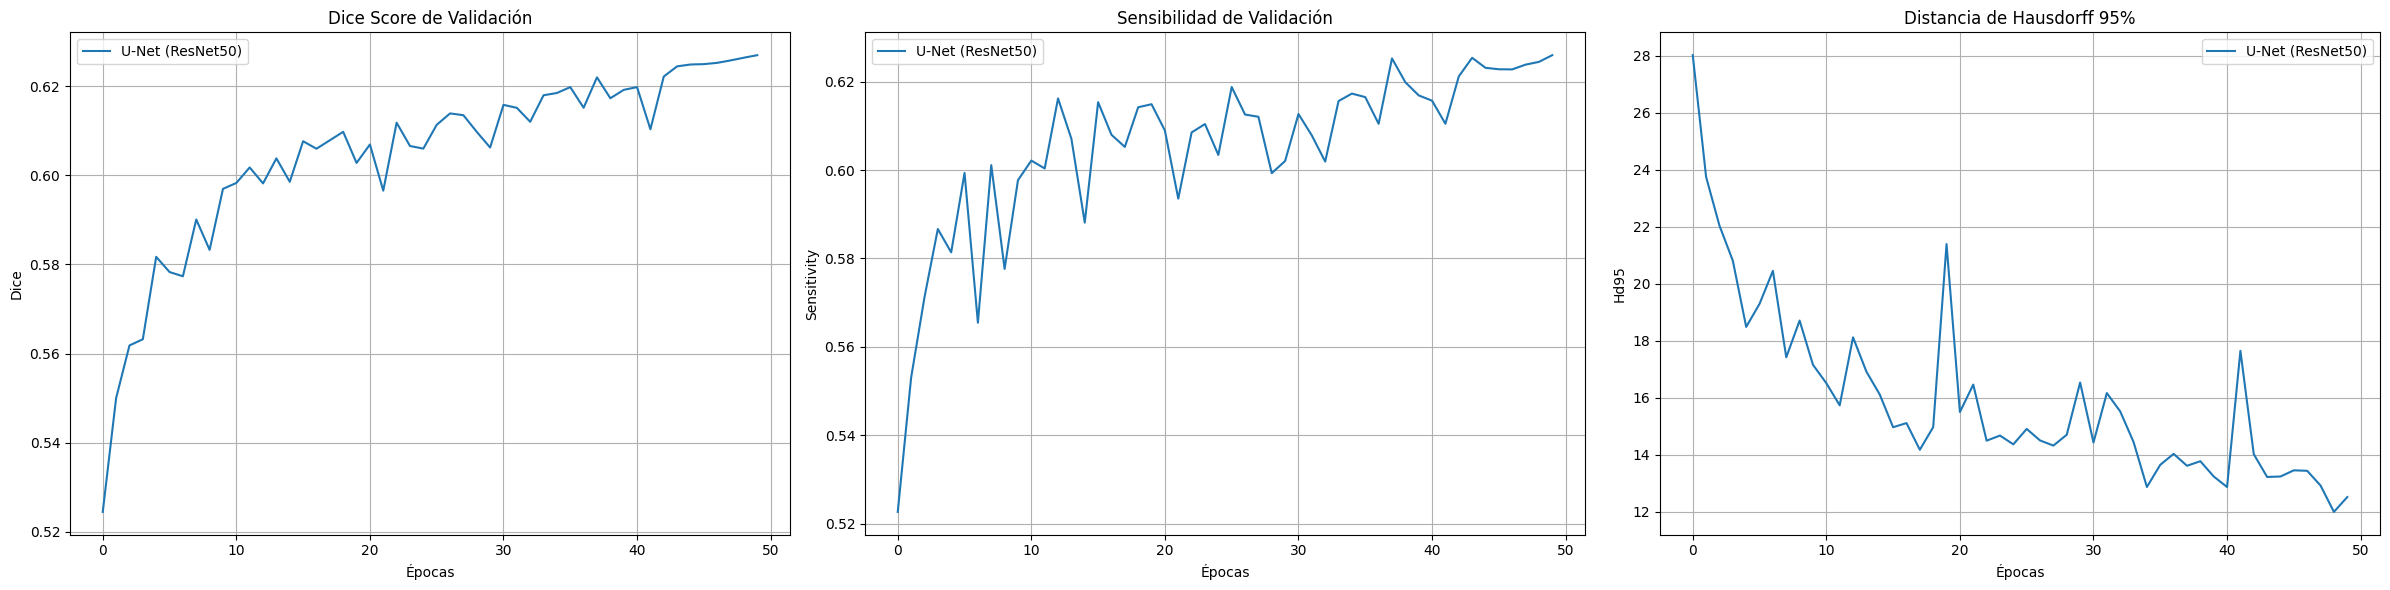

In [16]:
# Visualizar resultados comparativos
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
metrics_to_plot = ['val_dice', 'val_sensitivity', 'val_hd95']
titles = ['Dice Score de Validación', 'Sensibilidad de Validación', 'Distancia de Hausdorff 95%']
for i, metric in enumerate(metrics_to_plot):
    for name, history in results_history.items():
        axes[i].plot(history[metric], label=name)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Épocas')
    axes[i].set_ylabel(metric.replace("val_", "").capitalize())
    axes[i].legend()
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Resumen de Mejor Dice Score ---")
for name, score in best_scores.items():
    print(f"{name}: {score:.4f}")


## VISUALIZACIÓN DE PREDICCIONES COMPARATIVAS

In [ ]:
def visualize_results_and_gradcam(model, dataset, device, num_samples=5):
    model.load_state_dict(torch.load('best_model_u-net_(resnet50).pth', map_location=device))
    model.to(device).eval()
    
    class_colors = np.array([
        [  0,   0,   0],  # fondo
        [255,   0,   0],  # NCR
        [  0, 255,   0],  # ED
        [  0,   0, 255],  # ET
    ], dtype=np.uint8)
    target_layers = [model.decoder.blocks[-1].conv2]
    
    for idx in range(min(num_samples, len(dataset))):
        image, gt_mask = dataset[idx]
        image = image.to(device)
        
        flair = image[0].cpu().numpy()           # [H, W]
        flair_norm = (flair - flair.min()) / (flair.max() - flair.min() + 1e-8)
        image_rgb  = np.stack([flair_norm]*3, axis=2)  # [H, W, 3]
        
        input_tensor = image.unsqueeze(0)
        with torch.no_grad():
            output    = model(input_tensor)
            pred_mask = torch.softmax(output, dim=1).argmax(dim=1).squeeze().cpu().numpy()
        
        gt_rgb   = class_colors[gt_mask.cpu().numpy()]
        pred_rgb = class_colors[pred_mask]
        
        fig, axes = plt.subplots(1, 6, figsize=(24, 4))
        axes[0].imshow(flair, cmap='gray');        axes[0].set_title('FLAIR');        axes[0].axis('off')
        axes[1].imshow(gt_rgb);                    axes[1].set_title('Máscara Real'); axes[1].axis('off')
        axes[2].imshow(pred_rgb);                  axes[2].set_title('Predicción');   axes[2].axis('off')
        
        cam_idx = 3
        cam_targets = {'NCR (cls 1)':1, 'ED (cls 2)':2, 'ET (cls 3)':3}
        for title, cls in cam_targets.items():
            mask_for_target = (pred_mask == cls).astype(np.uint8)
            targets         = [SemanticSegmentationTarget(mask=mask_for_target, category=cls)]
            with GradCAM(model=model, target_layers=target_layers) as cam:
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
                cam_image     = show_cam_on_image(image_rgb, grayscale_cam, use_rgb=True)
            axes[cam_idx].imshow(cam_image)
            axes[cam_idx].set_title(f'Grad‑CAM {title}')
            axes[cam_idx].axis('off')
            cam_idx += 1
        
        plt.tight_layout()
        plt.show()

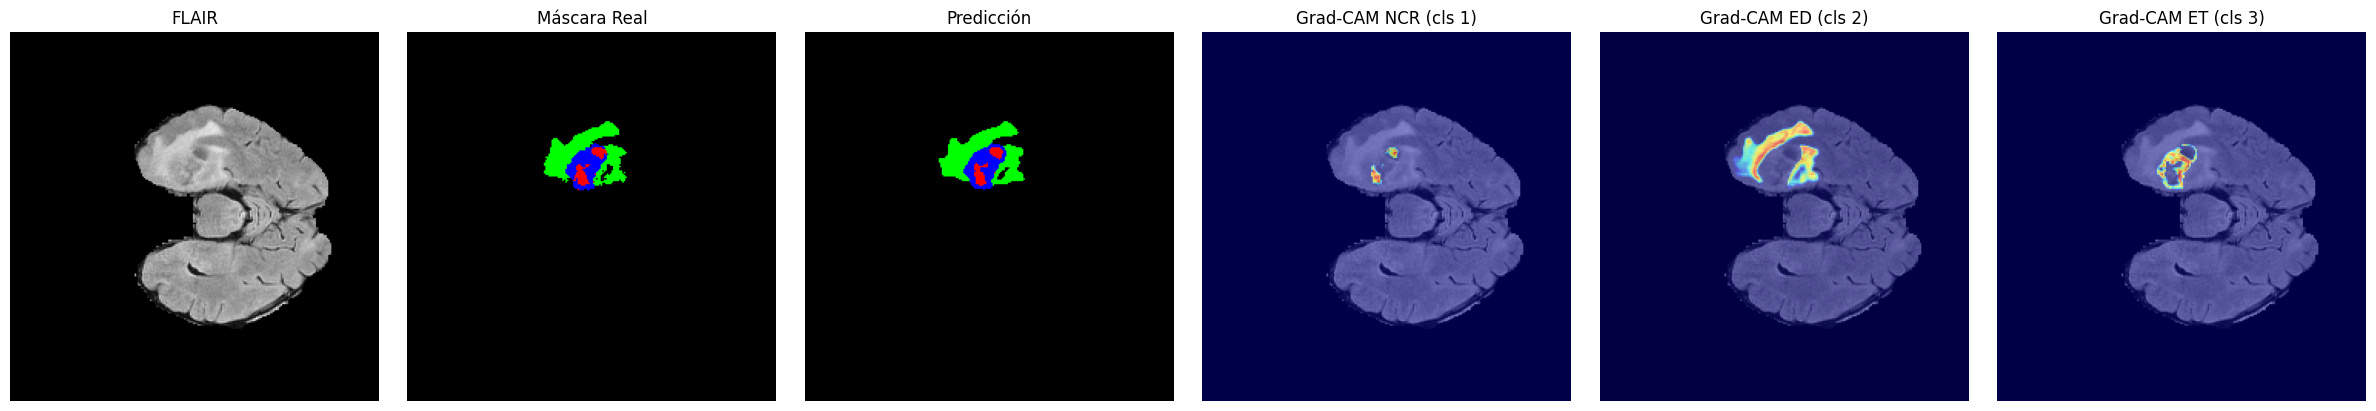

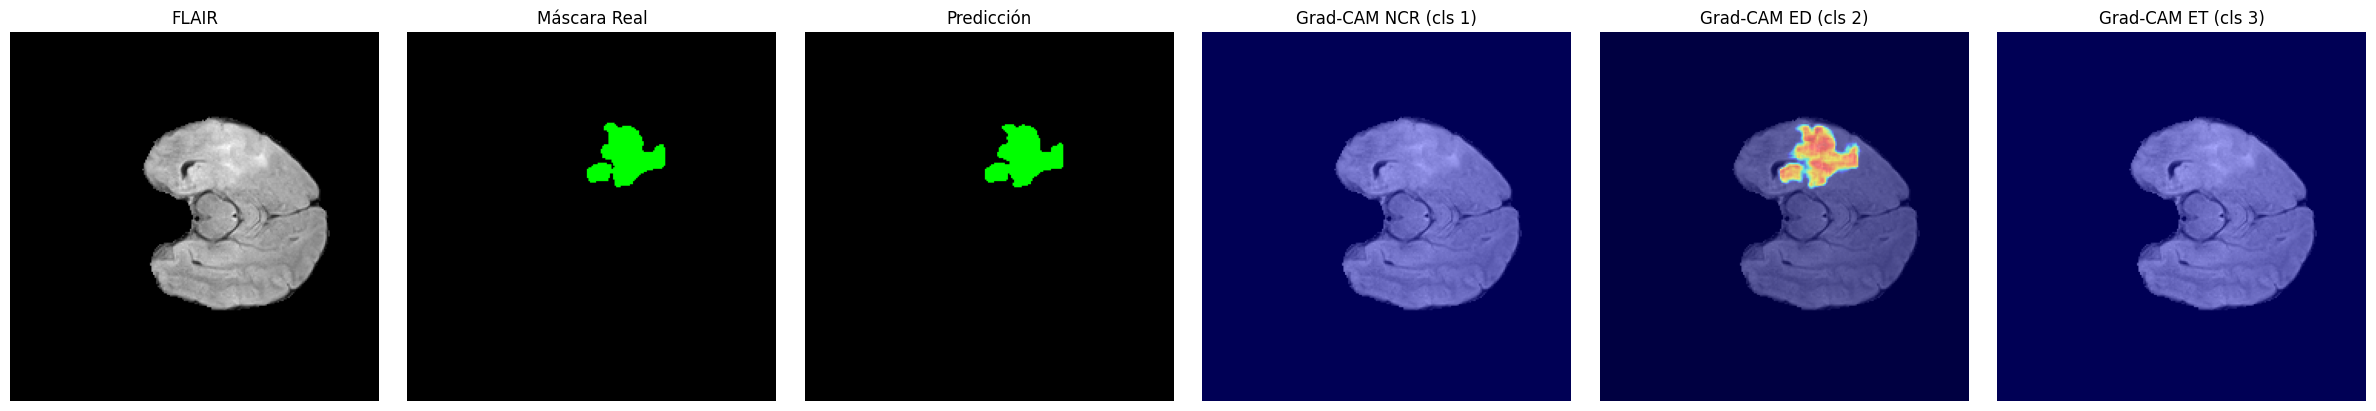

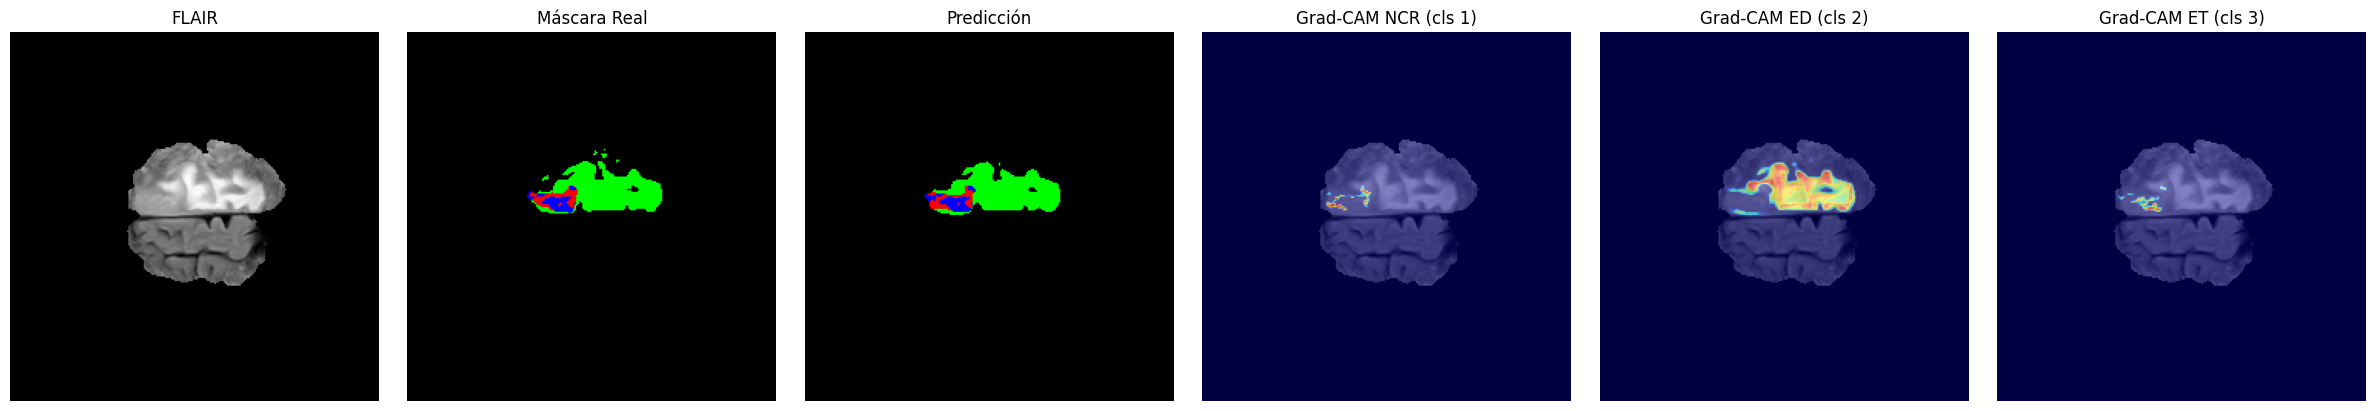

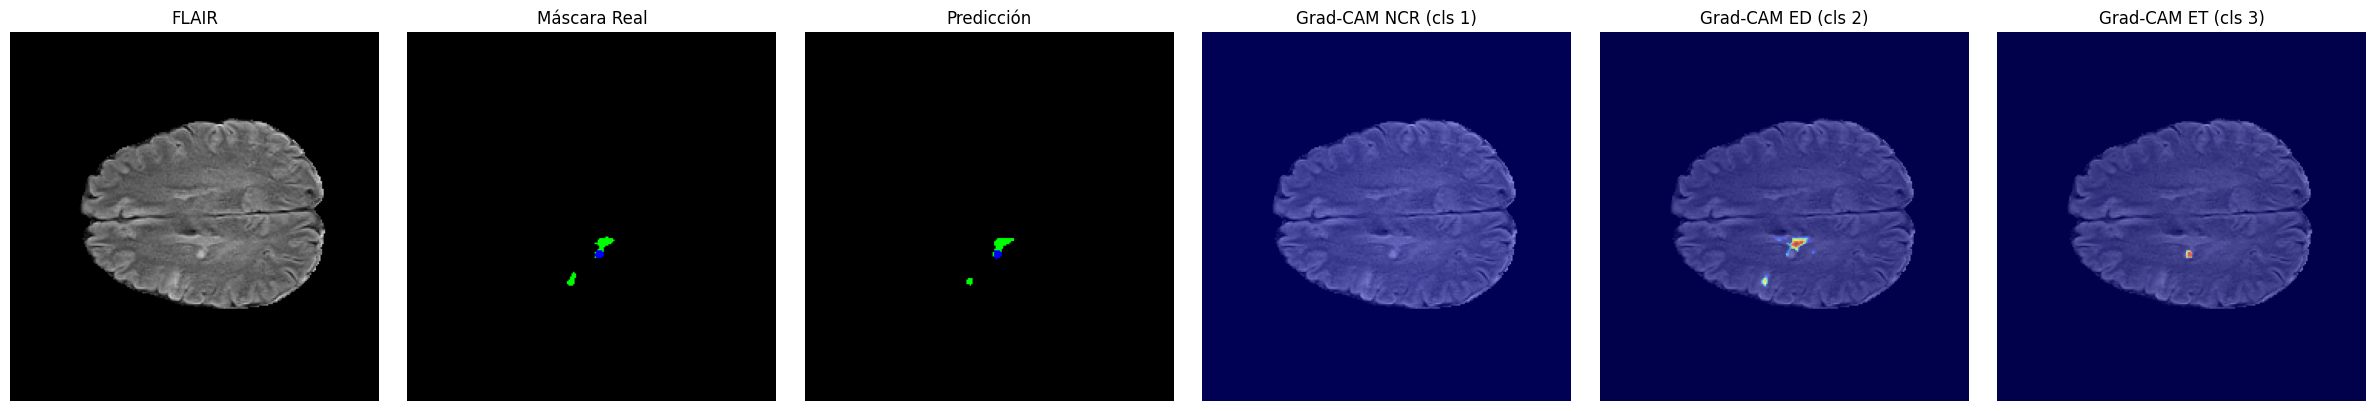

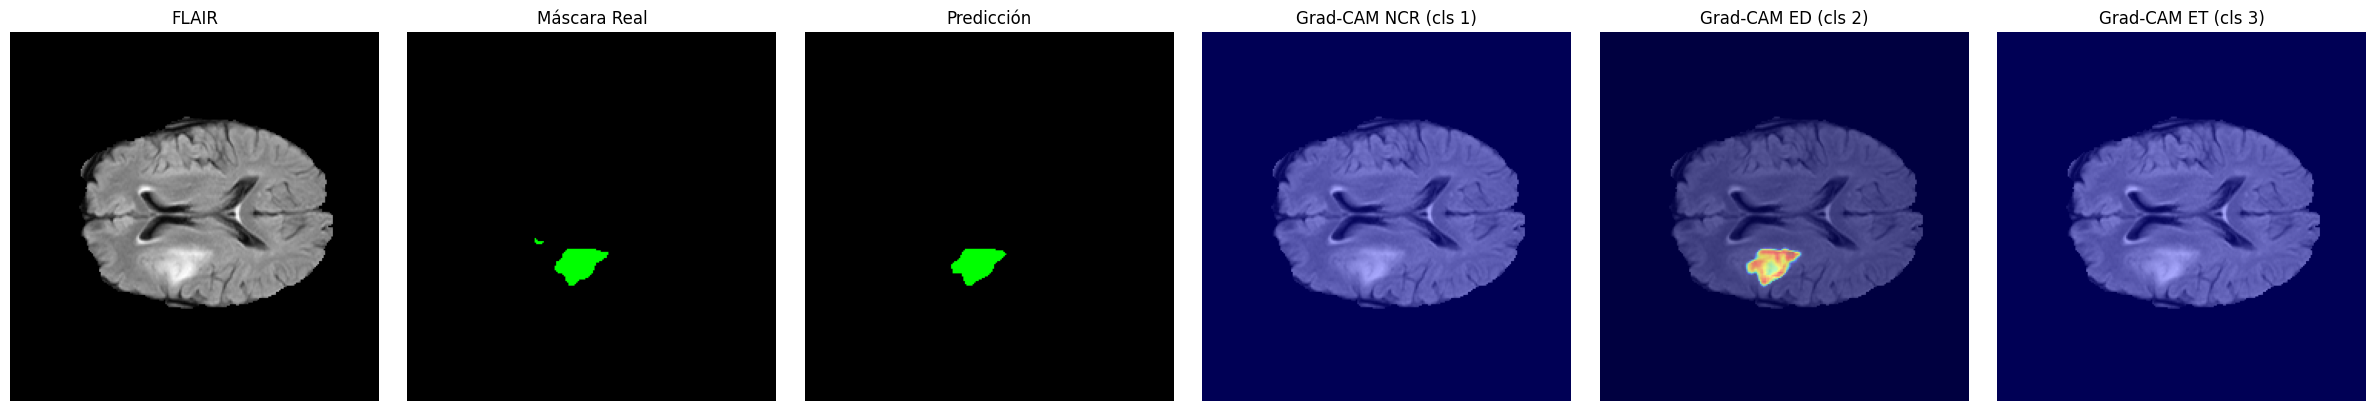

In [26]:
visualize_results_and_gradcam(
    model=models_to_train['U-Net (ResNet50)'],
    dataset=val_dataset,
    device=DEVICE,
    num_samples=5
)

In [20]:
def visualize_comparative_results(models, dataset, device, num_samples=3):
    class_colors = np.array([
        [  0,   0,   0],  # fondo
        [255,   0,   0],  # NCR
        [  0, 255,   0],  # ED
        [  0,   0, 255],  # ET
    ], dtype=np.uint8)
    
    for i in range(num_samples):
        image, gt_mask = dataset[i]
        image_vis = image[0, :, :].numpy()
        image_tensor = image.unsqueeze(0).to(device)
        gt_mask_rgb = class_colors[gt_mask.numpy()]
        
        num_models = len(models)
        fig, axes = plt.subplots(1, 2 + num_models, figsize=(6 * (2 + num_models), 6))
        
        axes[0].imshow(image_vis, cmap='gray'); axes[0].set_title('FLAIR Original'); axes[0].axis('off')
        axes[1].imshow(gt_mask_rgb); axes[1].set_title('Máscara Real'); axes[1].axis('off')
        
        ax_idx = 2
        for name, model in models.items():
            model_path = f'best_model_{name.replace(" ", "_").replace("+", "plus").lower()}.pth'
            if os.path.exists(model_path):
                model.load_state_dict(torch.load(model_path, map_location=device))
                model.eval()
                with torch.no_grad():
                    pred_output = model(image_tensor)
                    pred_mask = torch.softmax(pred_output, dim=1).argmax(dim=1).squeeze().cpu().numpy()
                
                pred_mask_rgb = class_colors[pred_mask]
                axes[ax_idx].imshow(pred_mask_rgb)
                axes[ax_idx].set_title(f'Pred: {name}')
            else:
                axes[ax_idx].text(0.5, 0.5, 'Modelo no encontrado', ha='center')
            axes[ax_idx].axis('off')
            ax_idx += 1
            
        plt.tight_layout()
        plt.show()



RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

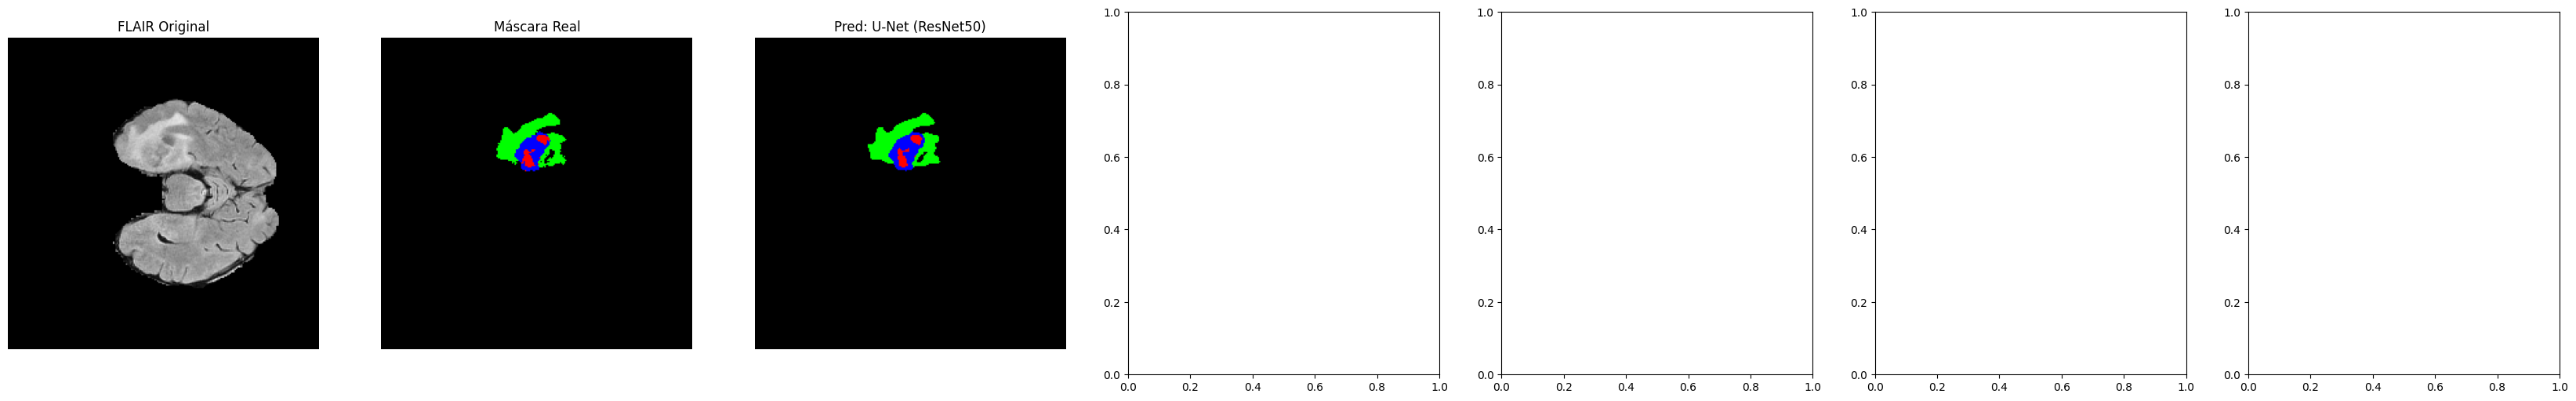

In [21]:
val_dataset_vis = BraTSDataset(val_data)
visualize_comparative_results(models_to_train, val_dataset_vis, DEVICE)